# stroke-alert

**Predictable variable: stroke**  
Aiming to early predict and alert the stroke risk based on individual's demographical or health data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pointbiserialr
import numpy as np

Original data:

In [2]:
df = pd.read_csv("AVC.csv")
df_original = df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Initial data cleaning

Converting categorical variables to numerical representations

In [4]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Apply label encoding to the categorical variables
encoder = LabelEncoder()
df[categorical_vars] = df[categorical_vars].apply(encoder.fit_transform)

Deleting columns:  
- ID,  
- ever_married

Records:  
- where BMI values are superior to 69

Correlation between ever_married and age: **68%**

In [5]:
continuous_var = 'age'

binary_var = 'ever_married'

print(f'Point-biserial correlation coefficients for {continuous_var}:')
correlation_coefficient, p_value = pointbiserialr(df[continuous_var], df[binary_var])
print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')


Point-biserial correlation coefficients for age:
ever_married: 0.6791 (p-value: 0.0000)


Deleting columns ID, ever_married, records where BMI values are superior to 69:

In [6]:
df = df.drop('id', axis=1)
df = df.drop('ever_married', axis=1)
df = df.drop(df[df['bmi'] >= 69].index) #IMC de 59 correspond à 170cm 200 Kg, les valeurs max sont à 97,6 (abérant)

Data records where BMI >= 69 (from original dataframe):

In [7]:
high_bmi_df = df_original[(df_original['bmi'] >= 69)]
high_bmi_df.sort_values(by='bmi', ascending=False)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
544,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0


Changing 'smoking_status' 0 ('Unknown') values to null:

In [8]:
# df['smoking_status'] = df['smoking_status'].replace(0, None)

### Gender

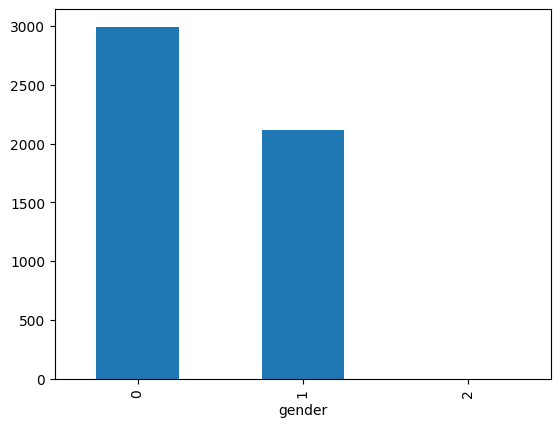

In [9]:
df.gender.value_counts().plot(kind='bar')
plt.show()

Removing 1 data sample with gender 'Other' (2)

In [10]:
df = df.drop(df[df['gender'] == 2].index)

### Residence type

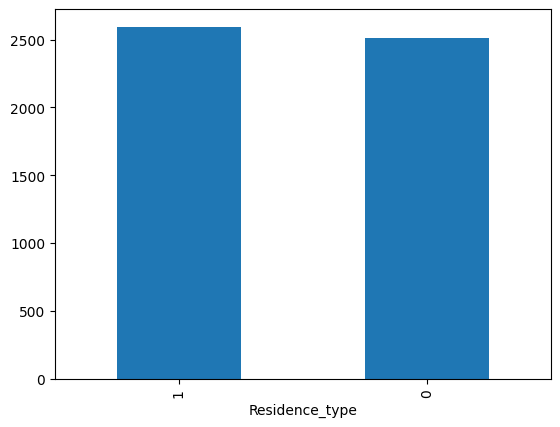

In [11]:
df.Residence_type.value_counts().plot(kind='bar')
plt.show()

### Work type

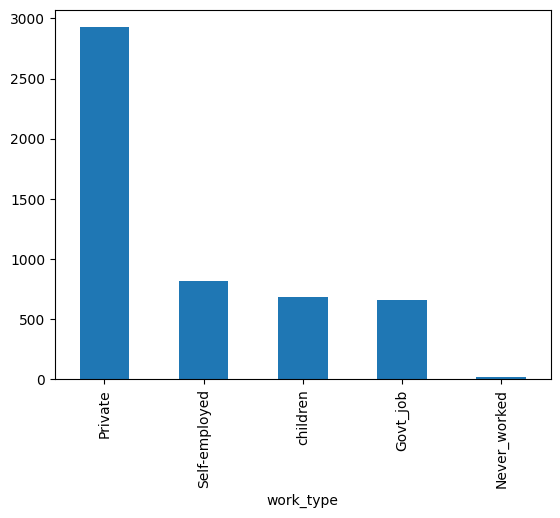

In [12]:
df_original.work_type.value_counts().plot(kind='bar')
plt.show()

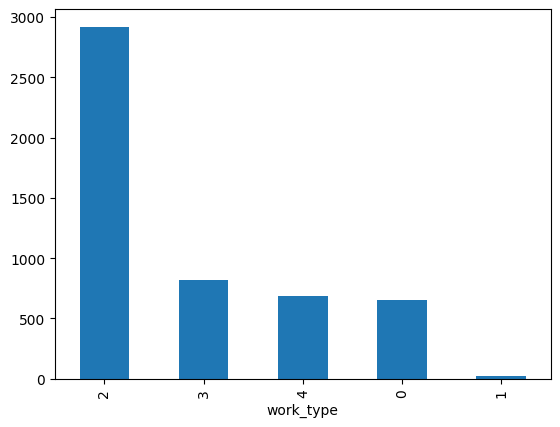

In [13]:
df.work_type.value_counts().plot(kind='bar')
plt.show()

### Smoking status

Original data:

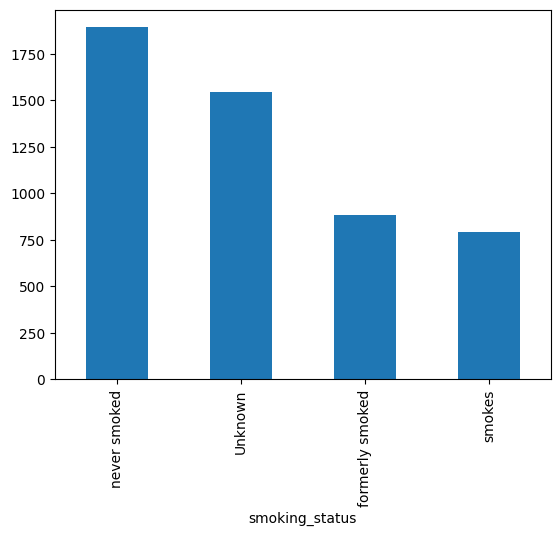

In [14]:
df_original.smoking_status.value_counts().plot(kind='bar')
plt.show()

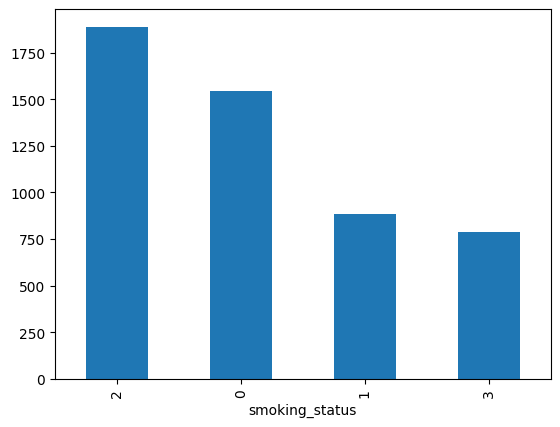

In [15]:
df.smoking_status.value_counts().plot(kind='bar')
plt.show()

### Hypertension

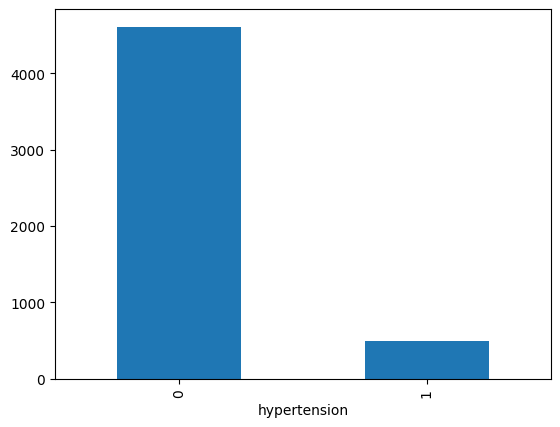

In [16]:
df.hypertension.value_counts().plot(kind='bar')
plt.show()

### Heart disease

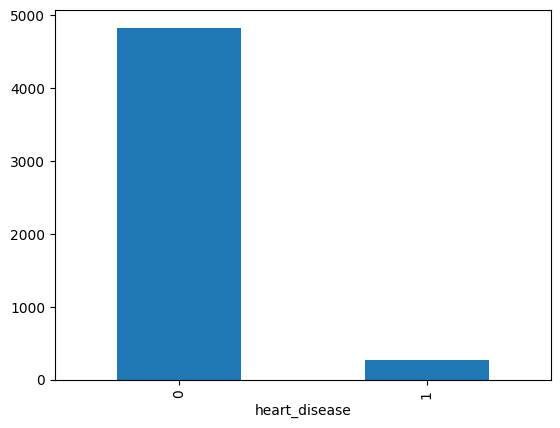

In [17]:
df.heart_disease.value_counts().plot(kind='bar')
plt.show()

### Stroke

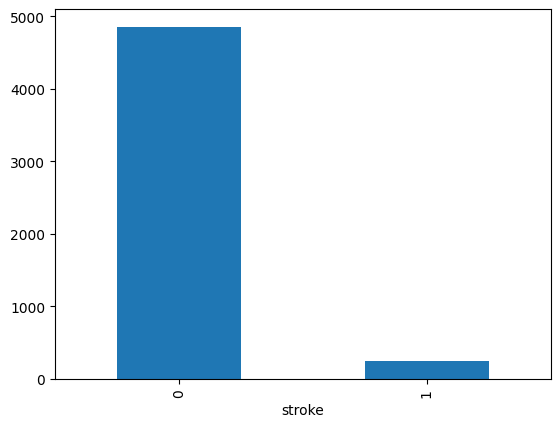

In [18]:
df.stroke.value_counts().plot(kind='bar')
plt.show()

### Age

Data distribution:

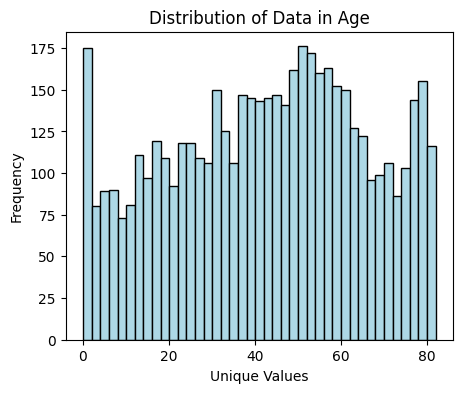

In [19]:
plt.figure(figsize=(5, 4))
plt.hist(df['age'], bins=41, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Age')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Calculating the histogram bin edges

In [20]:
# Calculate histogram values and bin edges
hist_values, bin_edges = np.histogram(df['age'], bins=41, range=(df['age'].min(), df['age'].max()))

# Assign histogram bins to DataFrame
df['age_histogram'] = np.digitize(df['age'], bins=bin_edges)

# Print start and end points of each bin
for i, (start, end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    print(f'Bin {i + 1}: Start: {start}, End: {end}')

Bin 1: Start: 0.08, End: 2.078048780487805
Bin 2: Start: 2.078048780487805, End: 4.07609756097561
Bin 3: Start: 4.07609756097561, End: 6.074146341463415
Bin 4: Start: 6.074146341463415, End: 8.07219512195122
Bin 5: Start: 8.07219512195122, End: 10.070243902439024
Bin 6: Start: 10.070243902439024, End: 12.06829268292683
Bin 7: Start: 12.06829268292683, End: 14.066341463414634
Bin 8: Start: 14.066341463414634, End: 16.064390243902437
Bin 9: Start: 16.064390243902437, End: 18.062439024390244
Bin 10: Start: 18.062439024390244, End: 20.060487804878047
Bin 11: Start: 20.060487804878047, End: 22.05853658536585
Bin 12: Start: 22.05853658536585, End: 24.056585365853657
Bin 13: Start: 24.056585365853657, End: 26.054634146341463
Bin 14: Start: 26.054634146341463, End: 28.052682926829267
Bin 15: Start: 28.052682926829267, End: 30.05073170731707
Bin 16: Start: 30.05073170731707, End: 32.048780487804876
Bin 17: Start: 32.048780487804876, End: 34.04682926829268
Bin 18: Start: 34.04682926829268, End: 

Age < 2.08 (first histogram bin) - values where stroke = 1: 

In [21]:
test_df = df[(df['age'] <= 2.08) & (df['stroke'] == 1)]
test_df.sort_values(by='age', ascending=False)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
162,0,1.32,0,0,4,1,70.37,NaN,0,1,1


Age < 2.08 (first histogram bin) - all values: 

In [22]:
test_df = df[(df['age'] <= 2.08)]
test_df.sort_values(by='age', ascending=False)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
2687,0,2.00,0,0,4,0,100.66,18.5,0,0,1
1371,1,2.00,0,0,4,1,94.75,18.0,0,0,1
3908,0,2.00,0,0,4,0,70.25,17.0,0,0,1
1990,1,2.00,0,0,4,1,112.92,18.4,0,0,1
4065,1,2.00,0,0,4,1,89.32,17.2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3968,1,0.16,0,0,4,0,69.79,13.0,0,0,1
3618,1,0.16,0,0,4,1,114.71,17.4,0,0,1
4021,1,0.16,0,0,4,1,109.52,13.9,0,0,1
1614,0,0.08,0,0,4,1,139.67,14.1,0,0,1


**Deleting the records where age < 2.08** (175 records)

In [23]:
df = df.drop(df[df['age'] <= 2.08].index)

## Correlation & Association

#### Continuous variables

In [24]:
df[['age','avg_glucose_level','bmi']].describe()

,age,avg_glucose_level,bmi
count,4930.000000,4930.000000,4735.000000
mean,44.725558,106.524576,29.211954
std,21.571810,45.724836,7.552102
min,3.000000,55.120000,11.300000
25%,28.000000,77.382500,24.050000
50%,46.000000,91.910000,28.300000
75%,61.000000,114.320000,33.300000
max,82.000000,271.740000,66.800000


#### Categorical variables (binary & nominal)

In [25]:
continuous_data_columns = ['age', 'avg_glucose_level', 'bmi']
df_categorical_data = df.drop(columns=continuous_data_columns)
df_categorical_data.head()

,gender,hypertension,heart_disease,work_type,Residence_type,smoking_status,stroke,age_histogram
0,1,0,1,2,1,1,1,34
1,0,0,0,3,0,2,1,31
2,1,0,1,2,0,2,1,40
3,0,0,0,2,1,3,1,25
4,0,1,0,3,0,2,1,40


#### Heatmap

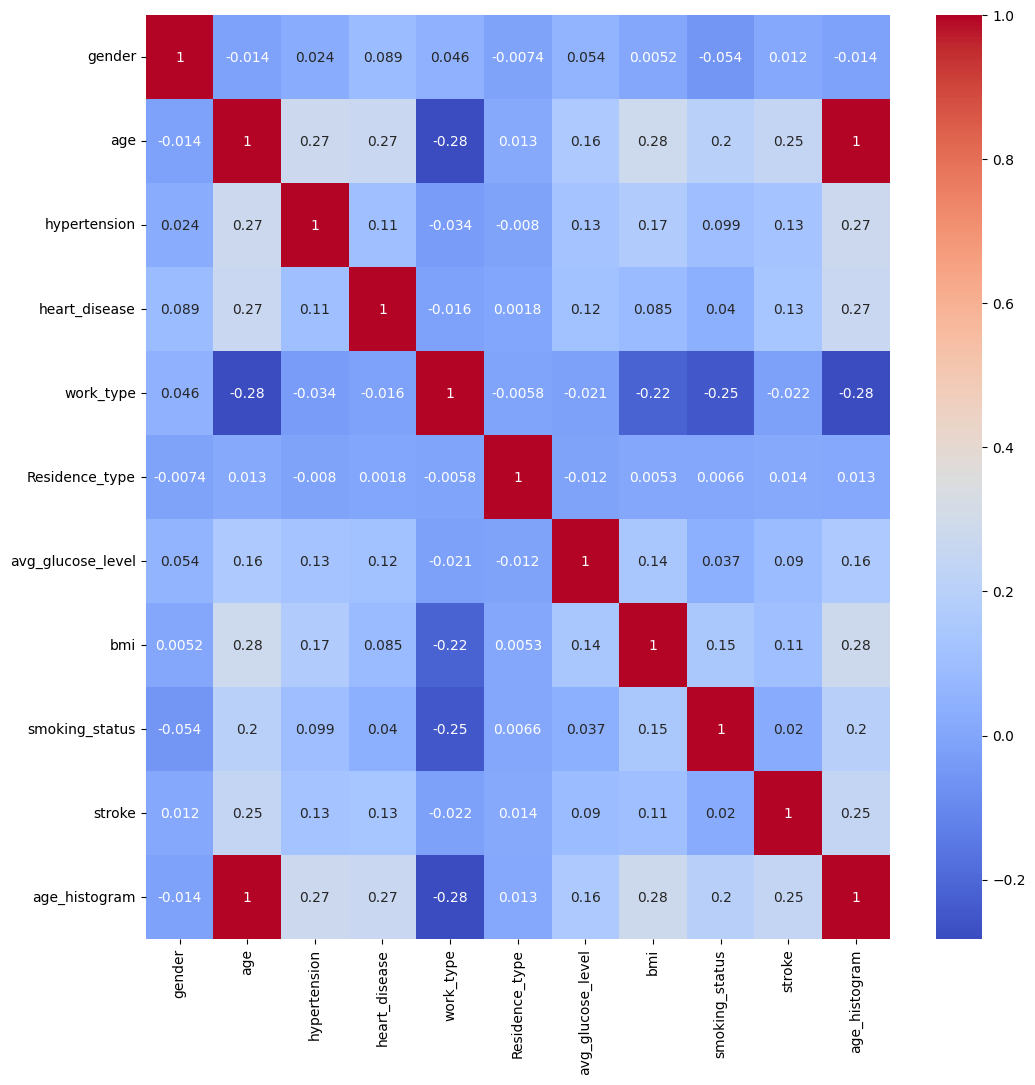

In [26]:
df = df.apply(LabelEncoder().fit_transform)

cor = df.corr()
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot=True,ax=ax,cmap='coolwarm');

In [27]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
0,1,64,0,1,2,1,3748,233,1,1,32
1,0,58,0,0,3,0,3487,408,2,1,29
2,1,77,0,1,2,0,2426,192,2,1,38
3,0,46,0,0,2,1,3285,211,3,1,23
4,0,76,1,0,3,0,3294,107,2,1,38


In [28]:
# sns.pairplot(df,kind="kde")

#### Correlation between categorical binary variable *stroke* and continuous variables *age*, *glucose_level*, and *bmi*

#### Correlation between categorical binary variable *stroke* and categorical binary & nominal variables *gender*, *hypertension*, *heart_disease*, *Residence_type*, *work_type*, and *smoking_status*

## Supervised classification (with 1 feature)

- **Splitting the DataFrame into training and testing sets**,  
- **Standardizing the features** using StandardScaler() to ensure they have a mean of 0 and a standard deviation of 1.
- Testing data set = 20%

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis=1),df['stroke'],test_size = .2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### -- Random Forrest

##### Algorithm

Les algorithmes de forêts aléatoires sont un cas particulier du Bagging appliqué aux arbres de décision (CART).
En plus du principe de Bagging, les forêts aléatoires ajoutent de l'aléa au niveau des variables. Pour chaque arbre on sélectionne un sous-échantillon par bootstrap d'individus et à chaque étape, la construction d'un nœud de l'arbre se fait sur un sous-ensemble de variables tirées aléatoirement.

Le principe de fonctionnement des forêts aléatoires est simple : de nombreux petits arbres de classification sont produits sur une fraction aléatoire de données.
Random Forest fait ensuite voter ces arbres de classification peu corrélés afin de déduire l'ordre et l'importance des variables explicatives.

Les forêts aléatoires présentent de multiples avantages par rapport à d'autres modèles de classification :
- Ce sont des modèles de classification multi-classe, efficaces sur les données de grande dimension.
- Il s'agit de méthodes statistiques robustes au niveau de l'identification des valeurs aberrantes (outliers en anglais).
- De manière générale, elles évitent l'overfitting, et ne nécessitent pas de validation croisée grâce aux échantillons "Out of bag".

Cependant, les modèle de Random Forest ont souvent un temps d'apprentissage plus long que les modèles classiques, et sont difficilement interprétables.

In [30]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
0,1,64,0,1,2,1,3748,233,1,1,32
1,0,58,0,0,3,0,3487,408,2,1,29
2,1,77,0,1,2,0,2426,192,2,1,38
3,0,46,0,0,2,1,3285,211,3,1,23
4,0,76,1,0,3,0,3294,107,2,1,38


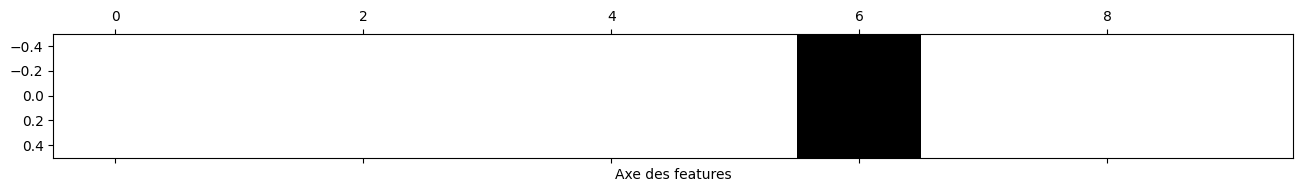

In [31]:
rfc1 = RandomForestClassifier()
rfe = RFE(estimator=rfc1, step=1, n_features_to_select = 1)
rfe.fit(X_train, y_train)
mask = rfe.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');


In [32]:
mask

array([False, False, False, False, False, False,  True, False, False,
       False])

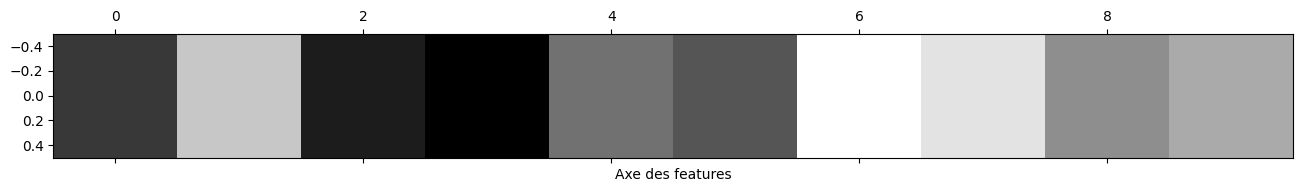

In [33]:
ranking = rfe.ranking_
plt.matshow(ranking.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

In [34]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
0,1,64,0,1,2,1,3748,233,1,1,32
1,0,58,0,0,3,0,3487,408,2,1,29
2,1,77,0,1,2,0,2426,192,2,1,38
3,0,46,0,0,2,1,3285,211,3,1,23
4,0,76,1,0,3,0,3294,107,2,1,38


##### Evaluation

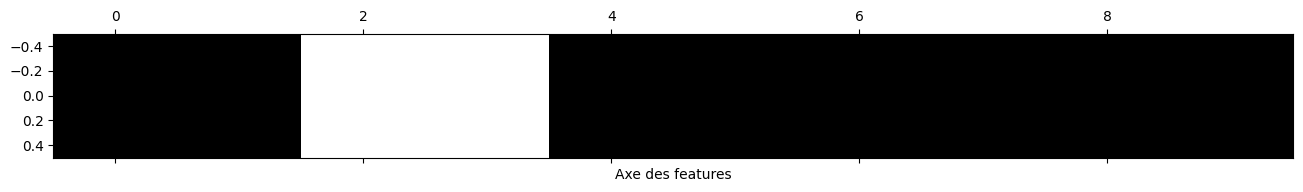

In [35]:
lm = LinearRegression()
rfc = RandomForestClassifier()

crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=rfc, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

mask = rfecv.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();


Nombre de features retenus : 8


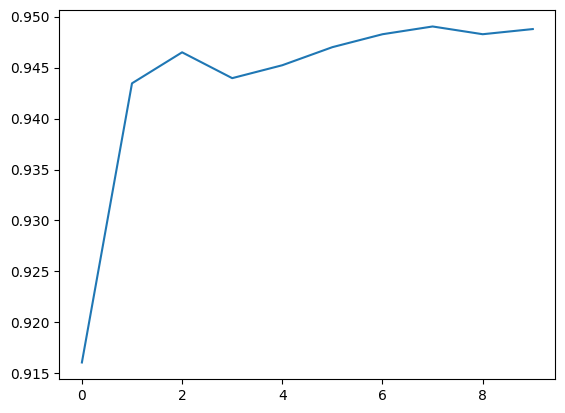

In [36]:
plt.plot(rfecv.cv_results_['mean_test_score']);
print("Nombre de features retenus :", rfecv.n_features_)

In [37]:
rfecv.cv_results_['mean_test_score']

array([0.9160693 , 0.94345731, 0.94649978, 0.94396492, 0.94523203,
       0.94700611, 0.94827353, 0.94903463, 0.94827482, 0.94878083])

#### -- Other Algorithm

##### Algorithm

In [38]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
0,1,64,0,1,2,1,3748,233,1,1,32
1,0,58,0,0,3,0,3487,408,2,1,29
2,1,77,0,1,2,0,2426,192,2,1,38
3,0,46,0,0,2,1,3285,211,3,1,23
4,0,76,1,0,3,0,3294,107,2,1,38


##### Evaluation

#### -- Other Algorithm

##### Algorithm

##### Evaluation

## Supervised classification (with multiple features)

## Notes

In [39]:
#séparer correlation variable continu/discontinu et pearson ou dautre metrics

In [40]:
#fumeur unknown : cb sont stroke ? si 0 ou très peu : delete !?

In [41]:
#enelver enfant sous 8ans